In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import matplotlib.colors as mcolors
from copy import deepcopy
from gudhi.representations import Landscape, PersistenceImage

from topofisher.input_simulators.noisy_ring import CircleSimulator

from topofisher.filtrations.numpy.alphaDTML import AlphaDTMLayer
from topofisher.filtrations.numpy.default_filtrations import RipsFiltration

from topofisher.vectorizations.numpy.custom_vectorizations import TOPK
from topofisher.vectorizations.numpy.order_statistics import OrderStatistics
from topofisher.vectorizations.numpy.vectorization_layer import VectorizationLayers
from topofisher.vectorizations.numpy.shorthand_layers import PersistenceImages, PersistenceLandscapes

from topofisher.fisher.Fisher import fisherFromVecs, fisherMOPED
from topofisher.fisher.imnn import FisherLayer, IMNNLayer, MopedLayer, ExtraDimLayer, plotLearningGraphs
from topofisher.fisher.plot_fisher_stats import plotContours2D, plotSummaryDerivativeHists, plot_derivative_convergence

from topofisher.pipelines.circle import CirclePipeline
from topofisher.pipelines.convergence_checks import fisher_estimates_wrt_step_size
from topofisher.pipelines.utils import readFromFile, writeToFile

2023-11-20 17:15:48.011000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 17:15:55.616188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Importlib

In [26]:
import importlib
import topofisher
importlib.reload(topofisher.fisher.Fisher)
importlib.reload(topofisher.fisher.imnn)
# importlib.reload(topofisher.vectorizations.numpy.order_statistics)
importlib.reload(topofisher.filtrations.numpy.filtration_layers)
importlib.reload(topofisher.filtrations.numpy.alphaDTML)
importlib.reload(topofisher.input_simulators.noisy_ring)
importlib.reload(topofisher.pipelines.pipeline)
importlib.reload(topofisher.pipelines.circle)

from topofisher.input_simulators.noisy_ring import CircleSimulator

from topofisher.filtrations.numpy.alphaDTML import AlphaDTMLayer
from topofisher.filtrations.numpy.default_filtrations import RipsFiltration, AlphaFiltration

# from topofisher.vectorizations.numpy.order_statistics import OrderStatistics
from topofisher.vectorizations.numpy.custom_vectorizations import TOPK
from topofisher.vectorizations.numpy.vectorization_layer import VectorizationLayers
from topofisher.vectorizations.numpy.shorthand_layers import PersistenceImages, PersistenceLandscapes
importlib.reload(topofisher.fisher.hztest)
importlib.reload(topofisher.fisher.Fisher)
importlib.reload(topofisher.fisher.imnn)
from topofisher.fisher.imnn import IMNNLayer, FisherLayer, MopedLayer, ExtraDimLayer, plotLearningGraphs
from topofisher.fisher.plot_fisher_stats import plotContours2D, plotSummaryDerivativeHists, plot_derivative_convergence


from topofisher.pipelines.circle import CirclePipeline

# AlphaDTM

## m = 0.9

In [2]:
circle_pipeline_mp9 = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 4000, n_d = 4000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.05, 0.01]),\
                                 filtLayer = AlphaDTMLayer(m = 0.9, max_hom_dim = 2, hom_dim_list = [0, 1], show_tqdm = True),
                                 vecLayer = None, fisherLayer = None, find_derivative = [True, True])
circle_pipeline_mp9.run_pipeline()

100%|██████████| 4000/4000 [00:35<00:00, 113.51it/s]


In [8]:
circle_pipeline_mp9.collect_benchmarks()
print("Theoretical bound for the Fisher matrix is ", np.round(circle_pipeline_mp9.benchmarks['TFM'].flatten(), 2))


Theoretical bound for the Fisher matrix is  [ 4.26792e+03 -8.00000e-02 -8.00000e-02  6.94504e+03]


### TOPK

In [104]:
vectorizations = [TOPK(bdp_type = "bd", is_binned = True, topk = 219, num_bins = 24), \
                  TOPK(bdp_type = "bd", is_binned = True, topk = 25, num_bins = 5)]

vecLayer = VectorizationLayers(vectorizations = vectorizations)
fisher = circle_pipeline_mp9.vectorize_and_fisher(vecLayer, MopedLayer())
fisher.show_and_test()

log FI =  16.75
FM =  [3905.18  392.65  392.65 4851.19]
Fractional bias =  [0. 0.]
Constraints =  [0.01606771 0.01441618]
The summaries satisfy the Gaussian Mean Only assumption.


In [29]:
import CompressedFisher
fid_arr = fisher.summaries[0].numpy()
der_arr = fisher.summaries[1:]
params_fid = np.array(circle_pipeline_mp9.theta_fid)
delta_params =  0.5*np.array(circle_pipeline_mp9.delta_theta) 
parameter_names = ["radius", "sigma "]

dict_param_steps = {parameter_names[i]:delta_params[i] for i in range(len(params_fid))}
dict_deriv_sims = {parameter_names[i]:np.array(der_arr[2*i: 2*i + 2]) for i in range(len(params_fid))}
nSimsCovMat = fid_arr.shape[0]
nSims_deriv = der_arr[0].shape[0]
cFisher = CompressedFisher.gaussianFisher(parameter_names, nSims_deriv, \
                                          include_covmat_param_depedence=True,
                                      deriv_finite_dif_accuracy=2)
compress_frac_split_ders = 0.
compress_frac_split_cov = 0.
covmat_sims = fid_arr
cFisher.initailize_covmat(covmat_sims, True)
cFisher.initailize_mean(covmat_sims)
cFisher.initailize_deriv_sims(dic_deriv_sims=dict_deriv_sims, dict_param_steps=dict_param_steps)
cFisher.generate_deriv_sim_splits(compress_fraction=compress_frac_split_ders)
"""
stnd_constraint    = cFisher.compute_fisher_forecast(parameter_names)
stnd_constraint_bias = cFisher.est_fisher_forecast_bias(parameter_names)
# print(cFisher._compute_fisher_matrix(parameter_names))
print(f'Parameter  \t standard Fisher \t Est. Fractional bias ')
for i,name in enumerate(parameter_names):
    print(f'{name}  \t\t  {stnd_constraint[i,i]**.5:.3f} \t\t     {(stnd_constraint_bias/stnd_constraint)[i,i]:.3f} ')
"""
cFisher._compute_fisher_matrix(parameter_names)
cov_terms = []
params_names = parameter_names
for i,n1 in enumerate(params_names):
            tmp_a = np.linalg.solve(cFisher.covmat_fisher,cFisher.deriv_covmat_fisher[n1])*cFisher._hartlap_fisher
            for j,n2 in enumerate(params_names[:i+1]):
                tmp_b = np.linalg.solve(cFisher.covmat_fisher,cFisher.deriv_covmat_fisher[n2])*cFisher._hartlap_fisher
                cov_term = +.5*np.trace(np.dot(tmp_a,tmp_b))
                cov_terms.append(cov_term)
                
cov_terms

/Users/karthikviswanathan/opt/anaconda3/envs/newEnvbkup/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/karthikviswanathan/opt/anaconda3/envs/newEnvbkup/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/karthikviswanathan/opt/anaconda3/envs/newEnvbkup/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/karthikviswanathan/opt/anaconda3/envs/newEnvbkup/lib/python3.8/site-packages/CompressedFisher/distributions/gaussian.py:247: RuntimeWarning: Degrees of freedom <= 0 for slice
  sim_covs+=finite_dif_weight/self._dict_param_steps[param_name]*np.cov(sims[finite_dif_index].T)
/Users/karthikviswanathan/opt/anaconda3/envs/newEnvbkup/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide

[1.2268939787672866, 0.9263649498684202, 47.79530231204103]

In [30]:
fisher.FMSig

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[ 1.23058481,  0.92915171],
       [ 0.92915171, 47.93908354]])>

In [31]:
cov_matrices = [np.cov(item.numpy().T) for item in fisher.summaries]
diag_cov = np.array([np.diag(item) for item in cov_matrices])
diag_cov

array([[4503.41179625, 5048.29117775],
       [4096.60841835, 4844.06177221],
       [4158.99133067, 5150.05334805],
       [4485.68074873, 4889.05467725],
       [4908.96674399, 4954.89291097]])

In [ ]:
abs_diff_cov = diag_cov[2::2, :] - diag_cov[1::2, :]
rel_diff_cov = np.abs(abs_diff_cov/diag_cov[1::2, :]/circle_pipeline_mp9.delta_theta)
rel_diff_cov

In [34]:
vecs = [vecLayer.vectorize_persistence_diagrams(pd) for pd in circle_pipeline_mp9.all_persistence_diagrams]

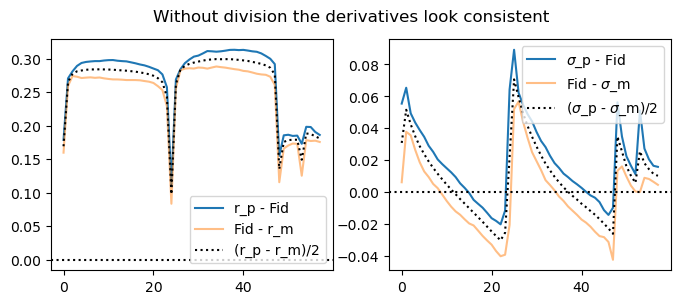

In [35]:
def plotDerivatives(ind1, ind2, ax, param):
    """
    true_der = (zz[ind2] - zz[ind1])/2.
    ax.plot((zz[ind2] - zz[0])/true_der, label = "Om_p - Fid")
    ax.plot((zz[0] - zz[ind1])/true_der, label = "Fid - Om_m", alpha = 0.5)
    ax.axhline(1, c = 'black', linestyle = 'dotted')
    """
    
    true_der = (zz[ind2] - zz[ind1])/2.
    ax.plot(zz[ind2] - zz[0], label = f"{param}_p - Fid")
    ax.plot(zz[0] - zz[ind1], label = f"Fid - {param}_m", alpha = 0.5)
    ax.plot(true_der, c = 'black', linestyle = 'dotted', label = f"({param}_p - {param}_m)/2")
    ax.axhline(0, c = 'black', linestyle = 'dotted')
    
    ax.legend()

zz = np.array([np.array(item).mean(axis = 0) for item in vecs])
ncols = 2
fig, axes = plt.subplots(nrows=1, ncols= ncols, figsize=(3 * ncols + 2 , 3))

plotDerivatives(1, 2, axes[0], "r")
plotDerivatives(3, 4, axes[1], "$\sigma$")



fig.suptitle("Without division the derivatives look consistent")
plt.show()

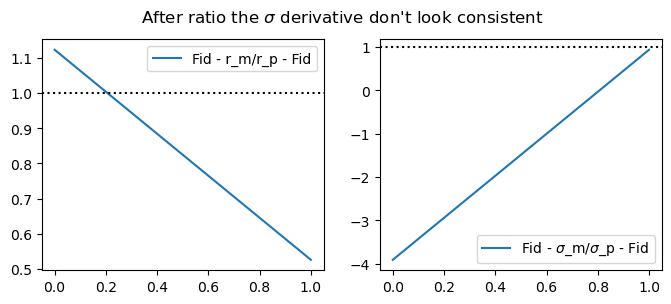

In [33]:
def plotDerivatives(ind1, ind2, ax, param):
    """
    true_der = (zz[ind2] - zz[ind1])/2.
    ax.plot((zz[ind2] - zz[0])/true_der, label = "Om_p - Fid")
    ax.plot((zz[0] - zz[ind1])/true_der, label = "Fid - Om_m", alpha = 0.5)
    ax.axhline(1, c = 'black', linestyle = 'dotted')
    """
    
    # true_der = (zz[ind2] - zz[ind1])/2.
    ax.plot((zz[ind2] - zz[0])/(zz[0] - zz[ind1]), label = f"Fid - {param}_m/{param}_p - Fid")
    #ax.plot(zz[0] - zz[ind1], label = f"Fid - {param}_m", alpha = 0.5)
    #ax.plot(true_der, c = 'black', linestyle = 'dotted', label = f"({param}_p - {param}_m)/2")
    ax.axhline(1, c = 'black', linestyle = 'dotted')
    
    ax.legend()

zz = np.array([np.array(item).mean(axis = 0) for item in fisher.summaries])
ncols = 2
fig, axes = plt.subplots(nrows=1, ncols= ncols, figsize=(3 * ncols + 2 , 3))

plotDerivatives(1, 2, axes[0], "r")
plotDerivatives(3, 4, axes[1], "$\sigma$")



fig.suptitle("After ratio the $\sigma$ derivative don't look consistent")
plt.show()

In [ ]:
def plotDerivatives(ind1, ind2, ax):
    """
    true_der = (zz[ind2] - zz[ind1])/2.
    ax.plot((zz[ind2] - zz[0])/true_der, label = "Om_p - Fid")
    ax.plot((zz[0] - zz[ind1])/true_der, label = "Fid - Om_m", alpha = 0.5)
    ax.axhline(1, c = 'black', linestyle = 'dotted')
    """
    
    true_der = (zz[ind2] - zz[ind1])/2.
    ax.plot(zz[ind2] - zz[0], label = "Om_p - Fid")
    ax.plot(zz[0] - zz[ind1], label = "Fid - Om_m", alpha = 0.5)
    ax.plot(true_der, c = 'black', linestyle = 'dotted')
    ax.axhline(0, c = 'black', linestyle = 'dotted')
    
    ax.legend()

zz = np.array([np.array(item).mean(axis = 0) for item in fisher.summaries])
ncols = 2
fig, axes = plt.subplots(nrows=1, ncols= ncols, figsize=(3 * ncols + 2 , 3))

plotDerivatives(1, 2, axes[0])
plotDerivatives(3, 4, axes[1])



fig.suptitle("Comparing difference of mean data vector for histogram of counts")
plt.show()

### Persistence Images

In [36]:
res = 24
pi_vec_layer = PersistenceImages(resolutions = [[res, res], [res, res]], bandwidths =  np.array([3e-2, 5e-2]))
pi_vecs = circle_pipeline_mp9.vectorize(pi_vec_layer)

In [105]:
importlib.reload(topofisher.fisher.hztest)
importlib.reload(topofisher.fisher.Fisher)
importlib.reload(topofisher.fisher.imnn)
from topofisher.fisher.imnn import IMNNLayer, FisherLayer, MopedLayer, ExtraDimLayer, plotLearningGraphs


model = tf.keras.Sequential(
    [
        ExtraDimLayer(tf.keras.layers.Conv2D(8, (3,3), padding='same', activation = 'relu',\
                                             input_shape=(res, res, 2))),
        ExtraDimLayer(tf.keras.layers.MaxPooling2D((2, 2), strides = 2)),
        
        # ExtraDimLayer(tf.keras.layers.Conv2D(4, (3,3), padding='same', activation = 'relu',\
                               #              input_shape=(res, res, 2))),
        #vExtraDimLayer(tf.keras.layers.MaxPooling2D((2, 2), strides = 2)),
            
        ExtraDimLayer(tf.keras.layers.Flatten()),
        tf.keras.layers.Dense(4, activation = tf.keras.layers.LeakyReLU(alpha=0.05)),
        ExtraDimLayer(tf.keras.layers.Dense(2))
    ]
)

pi_imnn_layer = IMNNLayer(model, verbose = 1, epochs = 150, data_splits = [0.4, 0.2, 0.4], \
                            callbacks = [tf.keras.callbacks.EarlyStopping(patience = 7, restore_best_weights = True)], \
                          show_fi = True, hz_strength = 2., hz_threshold = 0.2, show_hz = True)

# fisher = pi_imnn_layer.computeFisher(pi_vecs, circle_pipeline_mp9.delta_theta)

In [106]:
fisher = pi_imnn_layer.computeFisher(pi_vecs, circle_pipeline_mp9.delta_theta)

Epoch 1/150
4/4 [==============================] - 12s 1s/step - loss: -7.4888 - lnfi: 10.0438 - hz: 1.0000 - val_loss: -9.9183 - val_lnfi: 11.8357 - val_hz: 1.0000
Epoch 2/150
4/4 [==============================] - 1s 308ms/step - loss: -10.2691 - lnfi: 12.3321 - hz: 1.0000 - val_loss: -11.1630 - val_lnfi: 13.1039 - val_hz: 1.0000
Epoch 3/150
4/4 [==============================] - 1s 314ms/step - loss: -11.3887 - lnfi: 13.4748 - hz: 0.9962 - val_loss: -11.8714 - val_lnfi: 13.8101 - val_hz: 0.9999
Epoch 4/150
4/4 [==============================] - 2s 389ms/step - loss: -12.1581 - lnfi: 14.2583 - hz: 0.8750 - val_loss: -12.3468 - val_lnfi: 14.2723 - val_hz: 0.9802
Epoch 5/150
4/4 [==============================] - 2s 439ms/step - loss: -12.6714 - lnfi: 14.6021 - hz: 0.8180 - val_loss: -13.1879 - val_lnfi: 14.6065 - val_hz: 0.6796
Epoch 6/150
4/4 [==============================] - 2s 418ms/step - loss: -13.5998 - lnfi: 14.9811 - hz: 0.5691 - val_loss: -14.3301 - val_lnfi: 14.7951 - val_h

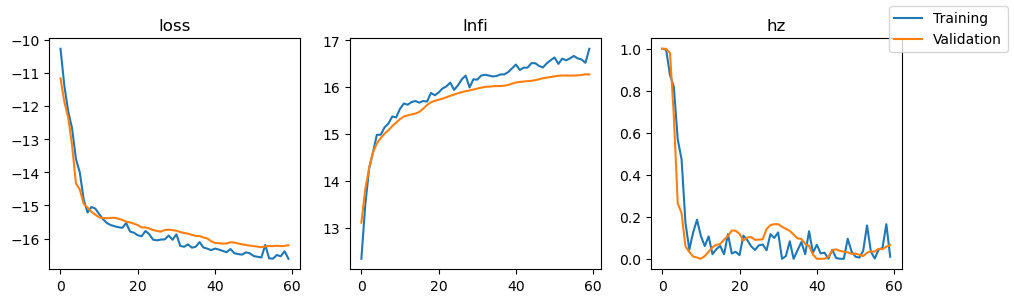

In [107]:
plotLearningGraphs(model.history.history, metric_list = ['loss', 'lnfi', 'hz'])

In [108]:
fisher.show_and_test()

log FI =  16.2
FM =  [3169.26 -133.13 -133.13 3430.58]
Fractional bias =  [0. 0.]
Constraints =  [0.0177777 0.0170872]
Covariance matrix at 0 could have parameter dependence with score = [0.3497 0.269 ] with diag_cov_m[0] = [25.92  4.02] and diag_cov_p[0] = [34.99  5.11].
The summaries satisfy the Gaussian Mean Only assumption.


In [109]:
fisher.FMSig

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[22.705826, 10.04535 ],
       [10.04535 ,  6.339434]], dtype=float32)>

In [38]:
fisher.FMSig

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[10.739966  , -0.6571534 ],
       [-0.6571534 ,  0.40447962]], dtype=float32)>

In [ ]:
import 

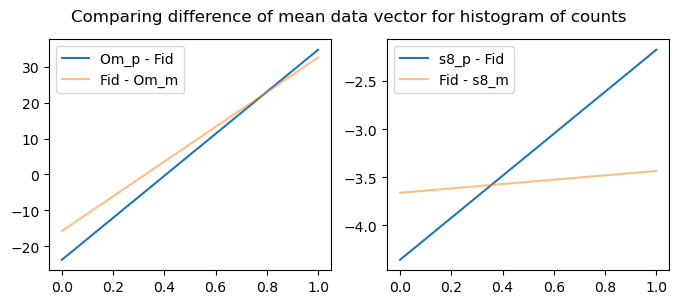

In [121]:
zz = np.array([np.array(item).mean(axis = 0) for item in fisher.summaries])
ncols = 2
fig, axes = plt.subplots(nrows=1, ncols= ncols, \
                             figsize=(3 * ncols + 2 , 3))
axes[0].plot((zz[2] - zz[0]), label = "Om_p - Fid")
axes[0].plot((zz[0] - zz[1]), label = "Fid - Om_m", alpha = 0.5)
# axes[0].axhline(0, c = 'black', linestyle = 'dotted')
axes[0].legend()

axes[1].plot((zz[4] - zz[0]), label = "s8_p - Fid")
axes[1].plot((zz[0] - zz[3]), label = "Fid - s8_m", alpha = 0.5)

# axes[1].axhline(0, c = 'black', linestyle = 'dotted')
axes[1].legend()

fig.suptitle("Comparing difference of mean data vector for histogram of counts")
plt.show()

In [42]:
[np.cov(item.numpy().T) for item in fisher.summaries]

[array([[95.08048007, 34.06014266],
        [34.06014266, 51.99500472]]),
 array([[82.66258022, 28.82578254],
        [28.82578254, 44.49781606]]),
 array([[99.39666048, 34.20692764],
        [34.20692764, 58.1825577 ]]),
 array([[101.32190794,  39.91135679],
        [ 39.91135679,  51.92026228]]),
 array([[100.85305953,  36.95836494],
        [ 36.95836494,  48.869326  ]])]

In [256]:
import pingouin as pg
[pg.multivariate_normality(item).pval for item in fisher.summaries], [topofisher.fisher.hztest.multivariate_normality(item) for item in fisher.summaries]

([0.054952699166140206,
  0.8247613965207129,
  0.41814501996073533,
  0.13485825573945043,
  0.1899495633868264],
 [<tf.Tensor: shape=(), dtype=float32, numpy=0.054959357>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.8250321>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.41819382>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.13487965>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.18998426>])

### Gaussianity checks

In [234]:

from scipy.stats import kstest, norm
# Function to generate random 2D unit vectors

def random_unit_vector():
    angle = np.random.uniform(0, 2*np.pi)
    return np.array([np.cos(angle), np.sin(angle)])

p_values = []
cnt = 0
sample = fisher.summaries[0]
data = (sample - np.mean(sample)) / np.std(sample, ddof=1)
num_vectors = 1000
vector_colors = []
# Perform KS test for each random unit vector
for i in range(num_vectors):
    # Generate a random unit vector
    random_vector = random_unit_vector()   
    
    # random_vector = np.array([0., 1.])  
    # Project the data onto the random unit vector
    projected_data = np.dot(sample, random_vector)
    
    projected_data = (projected_data - np.mean(projected_data)) / np.std(projected_data, ddof=1)
    ks_statistic, ks_p_value = kstest(projected_data, 'norm')


    # Check the result
    if ks_p_value > 0.05:
        cnt = cnt + 1
        
        p_values.append(ks_p_value)
        vector_colors.append(random_vector)
        # print(f'Random vector {i+1}: p-value = {ks_p_value:.4f} (Fail to reject null hypothesis - consistent with normality)')
    else:
        p_values.append(ks_p_value)
        vector_colors.append(random_vector)
        # print(f'p-value = {ks_p_value:.4f}')
print(cnt/1000)
# vec = np.array(vec)
# plt.scatter(vec[:, 0], vec[:, 1])

1.0


In [235]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

def lognorm_sf_tf(hz, psi, pmu):
    scale = tf.exp(pmu)
    z = (tf.math.log(tf.cast(hz, pmu.dtype)) - pmu) / psi
    ccdf = 0.5 * (1.0 + tf.math.erf(z / np.sqrt(2)))
    sf = 1.0 - ccdf
    return sf


def multivariate_normality(X, alpha=0.05):
    # Check input and remove missing values
    # X = tf.convert_to_tensor(X, dtype=tf.float64)
    assert X.shape.rank == 2, "X must be of shape (n_samples, n_features)."
    X = X[~tf.reduce_any(tf.math.is_nan(X), axis=1)]
    n, p = X.shape
    assert n >= 3, "X must have at least 3 rows."
    assert p >= 2, "X must have at least two columns."

    # Covariance matrix
    S = tfp.stats.covariance(X)
    S_inv = tf.linalg.pinv(S)  # Transpose is used instead of hermitian=True
    difT = X - tf.reduce_mean(X, axis=0)
    # Squared-Mahalanobis distances
    Dj = tf.linalg.diag_part(tf.matmul(tf.matmul(difT, S_inv), tf.linalg.matrix_transpose(difT)))
    Y = tf.matmul(tf.matmul(X, S_inv), tf.linalg.matrix_transpose(X))
    
    diag_Y_T = tf.linalg.diag_part(tf.linalg.matrix_transpose(Y))
    print(diag_Y_T[None, :].shape)
    tiled_diag_Y_T = tf.tile(diag_Y_T[tf.newaxis, :], [n, 1])
    # print(tf.reshape(tf.repeat(tf.linalg.diag_part(Y), n), (n , n)))
    # Djk = -2 * tf.linalg.matrix_transpose(Y) + tf.linalg.diag_part(Y)[:, None] + tf.tile(tf.linalg.diag_part(Y)[:, None], [1, n])
    Djk = -2 * tf.transpose(Y)  + tf.reshape(tf.repeat(tf.linalg.diag_part(Y), n), (n , n)) + tiled_diag_Y_T 
    #return Djk
    # Smoothing parameter
    b = 1 / (np.sqrt(2)) * ((2 * p + 1) / 4) ** (1 / (p + 4)) * (n ** (1 / (p + 4)))

    # Is matrix full-rank (columns are linearly independent)?
    if tf.linalg.matrix_rank(S) == p:
        hz = n * (
            1 / (n**2) * tf.reduce_sum(tf.reduce_sum(tf.exp(-(b**2) / 2 * Djk)))
            - 2
            * ((1 + (b**2)) ** (-p / 2))
            * (1 / n)
            * (tf.reduce_sum(tf.exp(-((b**2) / (2 * (1 + (b**2)))) * Dj)))
            + ((1 + (2 * (b**2))) ** (-p / 2))
        )
        
    else:
        hz = n * 4
    wb = (1 + b**2) * (1 + 3 * b**2)
    a = 1 + 2 * b**2
    # Mean and variance
    mu = 1 - a ** (-p / 2) * (1 + p * b**2 / a + (p * (p + 2) * (b**4)) / (2 * a**2))
    si2 = (
        2 * (1 + 4 * b**2) ** (-p / 2)
        + 2
        * a ** (-p)
        * (1 + (2 * p * b**4) / a**2 + (3 * p * (p + 2) * b**8) / (4 * a**4))
        - 4
        * wb ** (-p / 2)
        * (1 + (3 * p * b**4) / (2 * wb) + (p * (p + 2) * b**8) / (2 * wb**2))
    )

    # Lognormal mean and variance
    pmu = tf.math.log(tf.sqrt(mu**4 / (si2 + mu**2)))
    psi = tf.sqrt(tf.math.log1p(si2 / mu**2))  # Removed unnecessary log1p
    # print(hz.dtype, psi.dtype, pmu.dtype)
    # P-value
    pval = lognorm_sf_tf(hz, psi, pmu)

    return pval

def multivariate_normality_png(X, alpha=0.05):
    from scipy.stats import lognorm

    # Check input and remove missing values
    X = np.asarray(X)
    assert X.ndim == 2, "X must be of shape (n_samples, n_features)."
    X = X[~np.isnan(X).any(axis=1)]
    n, p = X.shape
    assert n >= 3, "X must have at least 3 rows."
    assert p >= 2, "X must have at least two columns."

    # Covariance matrix
    S = np.cov(X, rowvar=False, bias=True)
    S_inv = np.linalg.pinv(S, hermitian=True).astype(X.dtype)  # Preserving original dtype
    difT = X - X.mean(0)
    # Squared-Mahalanobis distances
    Dj = np.diag(np.linalg.multi_dot([difT, S_inv, difT.T]))
    Y = np.linalg.multi_dot([X, S_inv, X.T])
    diag_Y_T = tf.linalg.diag_part(tf.linalg.matrix_transpose(Y))
    tiled_diag_Y_T = tf.tile(diag_Y_T[None, :], [n, 1])
    Djk = -2 * Y.T + np.repeat(np.diag(Y.T), n).reshape(n, -1) + np.tile(np.diag(Y.T), (n, 1))
    #return Djk
    # Smoothing parameter
    b = 1 / (np.sqrt(2)) * ((2 * p + 1) / 4) ** (1 / (p + 4)) * (n ** (1 / (p + 4)))

    # Is matrix full-rank (columns are linearly independent)?
    if np.linalg.matrix_rank(S) == p:
        hz = n * (
            1 / (n**2) * np.sum(np.sum(np.exp(-(b**2) / 2 * Djk)))
            - 2
            * ((1 + (b**2)) ** (-p / 2))
            * (1 / n)
            * (np.sum(np.exp(-((b**2) / (2 * (1 + (b**2)))) * Dj)))
            + ((1 + (2 * (b**2))) ** (-p / 2))
        )
    else:
        hz = n * 4
    wb = (1 + b**2) * (1 + 3 * b**2)
    a = 1 + 2 * b**2
    # Mean and variance
    mu = 1 - a ** (-p / 2) * (1 + p * b**2 / a + (p * (p + 2) * (b**4)) / (2 * a**2))
    si2 = (
        2 * (1 + 4 * b**2) ** (-p / 2)
        + 2
        * a ** (-p)
        * (1 + (2 * p * b**4) / a**2 + (3 * p * (p + 2) * b**8) / (4 * a**4))
        - 4
        * wb ** (-p / 2)
        * (1 + (3 * p * b**4) / (2 * wb) + (p * (p + 2) * b**8) / (2 * wb**2))
    )

    # Lognormal mean and variance
    pmu = np.log(np.sqrt(mu**4 / (si2 + mu**2)))
    psi = np.sqrt(np.log1p(si2 / mu**2))
    # print(hz, psi, pmu)
    # P-value
    pval = lognorm.sf(hz, psi, scale=np.exp(pmu))
    return pval

# Example usage
# data = np.random.randn(100, 2)
multivariate_normality(fisher.summaries[1]) - multivariate_normality_png(fisher.summaries[1])


(1, 2000)


<tf.Tensor: shape=(), dtype=float64, numpy=-5.8513170280882765e-05>

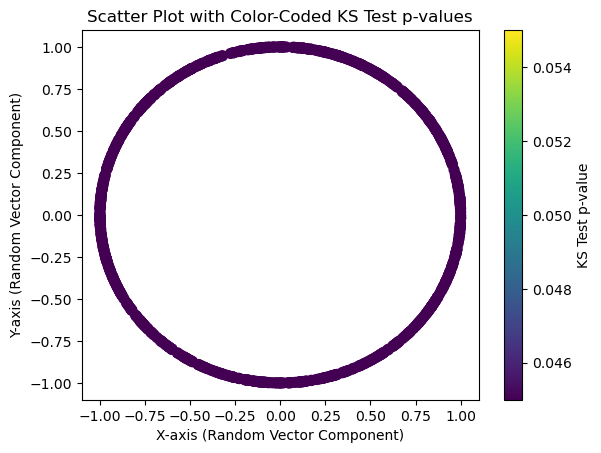

In [236]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Convert lists to NumPy arrays for plotting
p_values = np.minimum(np.array(p_values), 0.05)
vector_colors = np.array(vector_colors)

# Create a scatter plot with color-coded p-values
fig, ax = plt.subplots()
sc = ax.scatter(vector_colors[:, 0], vector_colors[:, 1], c=p_values, cmap='viridis', s=50)

# Add colorbar
norm = Normalize(vmin=p_values.min(), vmax=p_values.max())
sm = ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='KS Test p-value')

# Customize plot
ax.set_title('Scatter Plot with Color-Coded KS Test p-values')
ax.set_xlabel('X-axis (Random Vector Component)')
ax.set_ylabel('Y-axis (Random Vector Component)')

# Show the plot
plt.show()

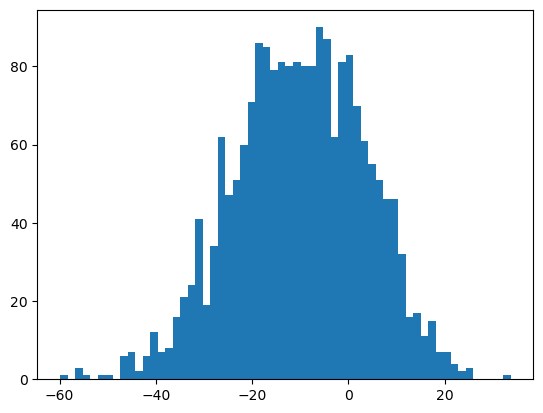

In [147]:
samples = fisher.summaries[2][:,0]
plt.hist(samples, bins = 60)
plt.show()

In [195]:
import pingouin as pg
from scipy.stats import kstest, norm
zz = [pg.multivariate_normality(item).pval for item in fisher.summaries]
print(zz)
is_ks_test = []
for idx, item in enumerate(fisher.summaries):
    p_vals = []
    for dim in range(tf.shape(fisher.summaries)[-1]):
        sample = item[:, dim] 
        sample = (sample - np.mean(sample)) / np.std(sample, ddof=1)
        ks_statistic, ks_p_value = kstest(sample, 'norm')
        p_vals.append(ks_p_value)
    print(p_vals)
    #is_ks_test.append(all(p_vals))

[0.0033121219294775846, 0.2749746107257832, 0.00030858790288040947]
[0.6305978871646594, 0.8572199868869573]
[0.904411038101713, 0.7812987248464265]
[0.9207095719252771, 0.950632437277336]


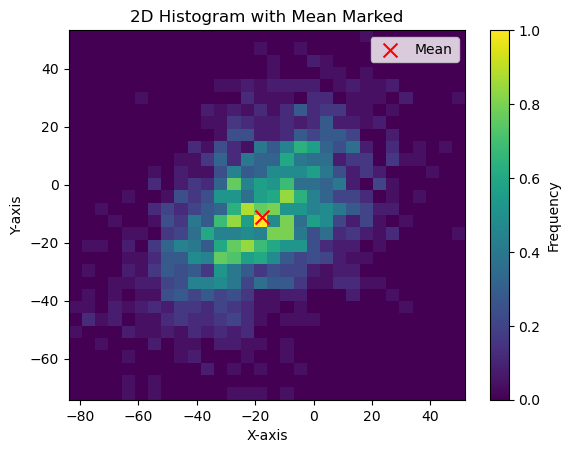

In [198]:
samples = fisher.summaries[1] 
# Create a 2D histogram
# Calculate mean of the samples
mean_sample = np.mean(samples, axis=0)

# Create a 2D histogram
plt.hist2d(samples[:, 0], samples[:, 1], bins=30, cmap='viridis')

# Mark the mean with a red cross
plt.scatter(mean_sample[0], mean_sample[1], marker='x', color='red', s=100, label='Mean')

# Add labels and a colorbar
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Histogram with Mean Marked')
plt.colorbar(label='Frequency')

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [200]:
sample = fisher.summaries[1]
from scipy.stats import skew, kurtosis
skewness = skew(sample, axis=0)
kurt = kurtosis(sample, axis=0)
skewness

array([-0.04992255, -0.00553356], dtype=float32)

In [202]:
sample = fisher.summaries[0]
from scipy.stats import skew, kurtosis
skewness = skew(sample, axis=0)
kurt = kurtosis(sample, axis=0)
skewness

array([-0.0669347 ,  0.10022883], dtype=float32)

In [75]:
param_list = ["fid", "r_m", "r_p", "sigma_m", "sigma_p"] 
for param, item in zip(param_list, fisher.summaries):
    print("Covariance at " + param, " = ", np.cov(item.numpy().T).flatten())

Covariance at fid  =  [35.85720757 -1.56411174 -1.56411174 60.01135206]
Covariance at r_m  =  [36.960865   -3.17132205 -3.17132205 57.58950731]
Covariance at r_p  =  [37.26277754 -4.85458816 -4.85458816 56.17141661]
Covariance at sigma_m  =  [36.45672461 -1.82533652 -1.82533652 60.45902579]
Covariance at sigma_p  =  [36.54265226 -2.02309493 -2.02309493 60.85029733]


## m = 0.1

In [76]:
circle_pipeline_mp1 = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 4000, n_d = 4000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.01, 0.002]),\
                                 filtLayer = AlphaDTMLayer(m = 0.1, max_hom_dim = 2, hom_dim_list = [0, 1], show_tqdm = True),
                                 vecLayer = None, fisherLayer = None, find_derivative = [True, True])
circle_pipeline_mp1.run_pipeline()

100%|██████████| 4000/4000 [00:24<00:00, 162.71it/s]


In [77]:
circle_pipeline_mp1.collect_benchmarks()
print("Theoretical bound for the Fisher matrix is ", np.round(circle_pipeline_mp1.benchmarks['TFM'].flatten(), 2))

Theoretical bound for the Fisher matrix is  [ 4.26792e+03 -8.00000e-02 -8.00000e-02  6.94504e+03]


### TOPK

In [78]:
vectorizations = [TOPK(bdp_type = "bd", is_binned = True, topk = 219, num_bins = 24), \
                  TOPK(bdp_type = "bd", is_binned = True, topk = 25, num_bins = 5)]

vecLayer = VectorizationLayers(vectorizations = vectorizations)
fisher = circle_pipeline_mp1.vectorize_and_fisher(vecLayer, MopedLayer())
show_fm_and_bias(fisher)

log FI =  14.92
FM =  [1240.18 1461.84 1461.84 4155.67]
Fractional bias =  [0. 0.]
Constraints =  [0.03711484 0.02027536]


In [79]:
param_list = ["fid", "r_m", "r_p", "sigma_m", "sigma_p"] 
for param, item in zip(param_list, fisher.summaries):
    print("Covariance at " + param, " = ", np.cov(item.numpy().T).flatten())

Covariance at fid  =  [1256.36326648 1257.23600951 1257.23600951 5059.67416332]
Covariance at r_m  =  [1368.67593027 1558.82666244 1558.82666244 5207.6770497 ]
Covariance at r_p  =  [1383.96794326 1555.48184139 1555.48184139 5247.37534678]
Covariance at sigma_m  =  [1221.32392428 1328.42126035 1328.42126035 4973.19983518]
Covariance at sigma_p  =  [1222.86230338 1336.68916104 1336.68916104 5004.32568425]


### Persistence Images

In [80]:
res = 24
pi_vec_layer = PersistenceImages(resolutions = [[res, res], [res, res]], bandwidths = [3e-2, 5e-2])
pi_vecs = circle_pipeline_mp1.vectorize(pi_vec_layer)

In [81]:
model = tf.keras.Sequential(
    [
        ExtraDimLayer(tf.keras.layers.Conv2D(8, (3,3), padding='same', activation = "relu", input_shape=(res, res, 2))),
        ExtraDimLayer(tf.keras.layers.MaxPooling2D((2, 2), strides=2)),
        ExtraDimLayer(tf.keras.layers.Flatten()),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(2)
    ]
)
pi_imnn_layer = IMNNLayer(model, verbose = 0, epochs = 50, data_splits = [0.4, 0.2, 0.4], \
                            callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)], \
                          show_bias = True)


fisher = pi_imnn_layer.computeFisher(pi_vecs, circle_pipeline_mp1.delta_theta)

In [83]:
show_fm_and_bias(fisher)

log FI =  15.02
FM =  [1270.8  1236.77 1236.77 3821.63]
Fractional bias =  [0. 0.]
Constraints =  [0.03389238 0.01954412]


In [84]:
param_list = ["fid", "r_m", "r_p", "sigma_m", "sigma_p"] 
for param, item in zip(param_list, fisher.summaries):
    print("Covariance at " + param, " = ", np.cov(item.numpy().T).flatten())

Covariance at fid  =  [ 19.63660305 -22.81434368 -22.81434368  85.89550826]
Covariance at r_m  =  [ 18.4494631  -21.90753506 -21.90753506  87.03157837]
Covariance at r_p  =  [ 18.74777436 -22.5612648  -22.5612648   88.0351482 ]
Covariance at sigma_m  =  [ 20.7620351  -23.20566191 -23.20566191  87.20808635]
Covariance at sigma_p  =  [ 21.12760012 -23.51698688 -23.51698688  87.30526585]


#### From PI0

In [85]:
pi0 = [item[:, :, :, 0:1] for item in pi_vecs]

model = tf.keras.Sequential(
    [
        ExtraDimLayer(tf.keras.layers.Conv2D(8, (3,3), padding='same', activation = "relu", input_shape=(res, res, 1))),
        ExtraDimLayer(tf.keras.layers.MaxPooling2D((2, 2), strides=2)),
        ExtraDimLayer(tf.keras.layers.Flatten()),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(2)
    ]
)
pi_imnn_layer = IMNNLayer(model, verbose = 0, epochs = 50, data_splits = [0.4, 0.2, 0.4], \
                            callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)], \
                          reg = tf.constant(0.), show_bias = True, show_fi = True)

fisher = pi_imnn_layer.computeFisher(pi0, circle_pipeline_mp1.delta_theta)

In [86]:
show_fm_and_bias(fisher)

param_list = ["fid", "r_m", "r_p", "sigma_m", "sigma_p"] 
for param, item in zip(param_list, fisher.summaries):
    print("Covariance at " + param, " = ", np.cov(item.numpy().T).flatten())

log FI =  13.95
FM =  [ 778.05 1309.9  1309.9  3678.5 ]
Fractional bias =  [0. 0.]
Constraints =  [0.05665004 0.02605367]
Covariance at fid  =  [17.84306067 -4.17767068 -4.17767068 30.84908351]
Covariance at r_m  =  [16.5468328  -4.52747503 -4.52747503 30.93909313]
Covariance at r_p  =  [16.50502482 -3.8951666  -3.8951666  29.73102829]
Covariance at sigma_m  =  [19.5001731  -4.49773024 -4.49773024 31.82879132]
Covariance at sigma_p  =  [19.53666522 -4.36633561 -4.36633561 31.58396587]


In [98]:
vectorizations = [TOPK(bdp_type = "bd", is_binned = True, topk = 219, num_bins = 24), \
                  #TOPK(bdp_type = "bd", is_binned = True, topk = 25, num_bins = 5)
                 ]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [0])
show_fm_and_bias(circle_pipeline_mp1.vectorize_and_fisher(vecLayer, MopedLayer()))

log FI =  13.16
FM =  [ 673.33 1552.53 1552.53 4350.99]
Fractional bias =  [0. 0.]
Constraints =  [0.0915364  0.03600919]


#### From PI1

In [128]:
pi1 = [item[:, :, :, 1:2] for item in pi_vecs]

model = tf.keras.Sequential(
    [
        ExtraDimLayer(tf.keras.layers.Conv2D(8, (3,3), padding='same', activation = "relu", input_shape=(res, res, 1))),
        ExtraDimLayer(tf.keras.layers.MaxPooling2D((2, 2), strides=2)),
        ExtraDimLayer(tf.keras.layers.Flatten()),
        tf.keras.layers.Dense(12, activation="relu"),
        tf.keras.layers.Dense(2)
    ]
)
pi_imnn_layer = IMNNLayer(model, verbose = 0, epochs = 50, data_splits = [0.4, 0.2, 0.4], \
                            callbacks = [tf.keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)], \
                          reg = tf.constant(0.), show_bias = True, show_fi = True)

fisher = pi_imnn_layer.computeFisher(pi1, circle_pipeline_mp1.delta_theta)

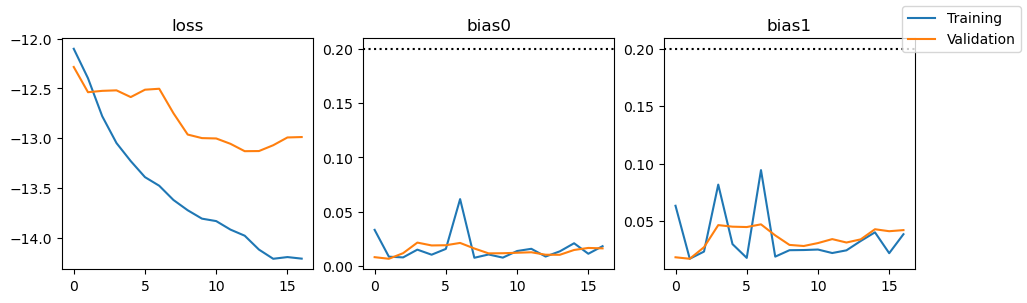

In [129]:
plotLearningGraphs(model.history.history, metric_list = ['loss', 'bias0', 'bias1'])

In [130]:
show_fm_and_bias(fisher)

param_list = ["fid", "r_m", "r_p", "sigma_m", "sigma_p"] 
for param, item in zip(param_list, fisher.summaries):
    print("Covariance at " + param, " = ", np.cov(item.numpy().T).flatten())

log FI =  13.4
FM =  [ 478.42 -178.66 -178.66 1446.7 ]
Fractional bias =  [0.   0.01]
Constraints =  [0.04681099 0.02691927]
Covariance at fid  =  [1.23975568 1.12935765 1.12935765 2.748211  ]
Covariance at r_m  =  [1.22291103 1.02949475 1.02949475 2.58542251]
Covariance at r_p  =  [1.20389235 1.03726245 1.03726245 2.56877872]
Covariance at sigma_m  =  [1.21823826 1.05727967 1.05727967 2.80085965]
Covariance at sigma_p  =  [1.24551152 1.08416122 1.08416122 2.81477008]


In [109]:
vectorizations = [#TOPK(bdp_type = "bd", is_binned = True, topk = 219, num_bins = 24), \
                  TOPK(bdp_type = "bd", is_binned = True, topk = 25, num_bins = 5)]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [1])
show_fm_and_bias(circle_pipeline_mp1.vectorize_and_fisher(vecLayer, MopedLayer()))

log FI =  13.51
FM =  [ 373.47  133.14  133.14 2017.85]
Fractional bias =  [0.   0.01]
Constraints =  [0.05236513 0.02252806]


In [116]:
show_fm_and_bias(fisher)

log FI =  13.65
FM =  [ 549.28 -183.6  -183.6  1597.31]
Fractional bias =  [0. 0.]
Constraints =  [0.04351194 0.02551595]


In [110]:
vectorizations = [#TOPK(bdp_type = "bd", is_binned = True, topk = 219, num_bins = 24), \
                  TOPK(bdp_type = "bd", is_binned = True, topk = 25, num_bins = 5)]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [1])
show_fm_and_bias(circle_pipeline.vectorize_and_fisher(vecLayer, MopedLayer()))

log FI =  13.51
FM =  [ 379.46  137.04  137.04 1996.11]
Fractional bias =  [0. 0.]
Constraints =  [0.05198373 0.02266519]


## m = 0.1

In [39]:
vectorizations = [TOPK(bdp_type = "bd", is_binned = True, topk = 219, num_bins = 24), \
                  TOPK(bdp_type = "bd", is_binned = True, topk = 25, num_bins = 5)]

vecLayer = VectorizationLayers(vectorizations = vectorizations)
fisherLayer = MopedLayer()
circle_pipeline_mp1 = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 4000, n_d = 4000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.1, 0.02]),\
                                 filtLayer = AlphaDTMLayer(m = 0.1, max_hom_dim = 2, hom_dim_list = [0, 1], show_tqdm = True),
                                 vecLayer = None, fisherLayer = None, find_derivative = [True, True])
circle_pipeline_mp1.run_pipeline()

100%|██████████| 4000/4000 [00:23<00:00, 173.72it/s]


In [24]:
vectorizations = [TOPK(bdp_type = "bd", is_binned = True, topk = 219, num_bins = 24), \
                  TOPK(bdp_type = "bd", is_binned = True, topk = 25, num_bins = 5)]

vecLayer = VectorizationLayers(vectorizations = vectorizations)

show_fm_and_bias(circle_pipeline_mp1.vectorize_and_fisher(vecLayer, MopedLayer()))

log FI =  15.01
FM =  [1123.36 1187.22 1187.22 4188.85]
Fractional bias =  [0. 0.]
Constraints =  [0.03564902 0.01846117]


## Persistence Images

### m = 0.9

In [65]:
res = 24
pi_vec_layer = PersistenceImages(resolutions = [[res, res], [res, res]], bandwidths = [3e-2, 5e-2])
circle_pipeline_pi = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 10000, n_d = 10000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.01, 0.002]),\
                                 filtLayer = AlphaDTMLayer(m = 0.9, max_hom_dim = 2, hom_dim_list = [0, 1], show_tqdm = True),
                                 vecLayer = pi_vec_layer, fisherLayer = None, find_derivative = [True, True])
circle_pipeline_pi.run_pipeline()

100%|██████████| 10000/10000 [01:17<00:00, 128.86it/s]


In [ ]:
model = tf.keras.Sequential(
    [
        ExtraDimLayer(tf.keras.layers.Conv2D(8, (3,3), padding='same', activation = "relu", input_shape=(res, res, 2))),
        ExtraDimLayer(tf.keras.layers.MaxPooling2D((2, 2), strides=2)),
        ExtraDimLayer(tf.keras.layers.Flatten()),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(2)
    ]
)
pi_imnn_layer = IMNNLayer(model, verbose = 1, epochs = 20, data_splits = [0.4, 0.2, 0.4], \
                            callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3)], reg = tf.constant(0.),\
                          show_bias = True)

fisher = pi_imnn_layer.computeFisher(circle_pipeline_pi.all_vecs, circle_pipeline_pi.delta_theta)

In [73]:
show_fm_and_bias(fisher)

log FI =  16.58
FM =  [3545.95  242.1   242.1  4475.79]
Fractional bias =  [0. 0.]
Constraints =  [0.01682431 0.01497506]


### m = 0.1

In [74]:
res = 24
pi_vec_layer = PersistenceImages(resolutions = [[res, res], [res, res]], bandwidths = [3e-2, 5e-2])
circle_pipeline_pi = CirclePipeline(ncirc= 200, nback = 20, bgmAvg = 1., n_s = 10000, n_d = 10000, \
                                 theta_fid = tf.constant([1., 0.2]), delta_theta = tf.constant([0.01, 0.002]),\
                                 filtLayer = AlphaDTMLayer(m = 0.1, max_hom_dim = 2, hom_dim_list = [0, 1], show_tqdm = True),
                                 vecLayer = pi_vec_layer, fisherLayer = None, find_derivative = [True, True])
circle_pipeline_pi.run_pipeline()

100%|██████████| 10000/10000 [01:19<00:00, 126.33it/s]


In [ ]:
model = tf.keras.Sequential(
    [
        ExtraDimLayer(tf.keras.layers.Conv2D(8, (3,3), padding='same', activation = "relu", input_shape=(res, res, 2))),
        ExtraDimLayer(tf.keras.layers.MaxPooling2D((2, 2), strides=2)),
        ExtraDimLayer(tf.keras.layers.Flatten()),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(2)
    ]
)
pi_imnn_layer = IMNNLayer(model, verbose = 1, epochs = 30, data_splits = [0.4, 0.2, 0.4], \
                            callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)], reg = tf.constant(0.),\
                          show_bias = True)

fisher = pi_imnn_layer.computeFisher(circle_pipeline_pi.all_vecs, circle_pipeline_pi.delta_theta)

In [80]:
show_fm_and_bias(fisher)


log FI =  15.02
FM =  [1345.02 1294.35 1294.35 3718.08]
Fractional bias =  [0. 0.]
Constraints =  [0.03343707 0.02011096]


In [119]:
vectorizations = [TOPK(bdp_type = "bd", is_binned = True, topk = 219, num_bins = 24), \
                  TOPK(bdp_type = "bd", is_binned = True, topk = 25, num_bins = 5)
                 ]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [0, 1])
show_fm_and_bias(circle_pipeline.vectorize_and_fisher(vecLayer, MopedLayer()))

log FI =  15.13
FM =  [1151.83 1213.21 1213.21 4498.12]
Fractional bias =  [0. 0.]
Constraints =  [0.03482369 0.01762194]


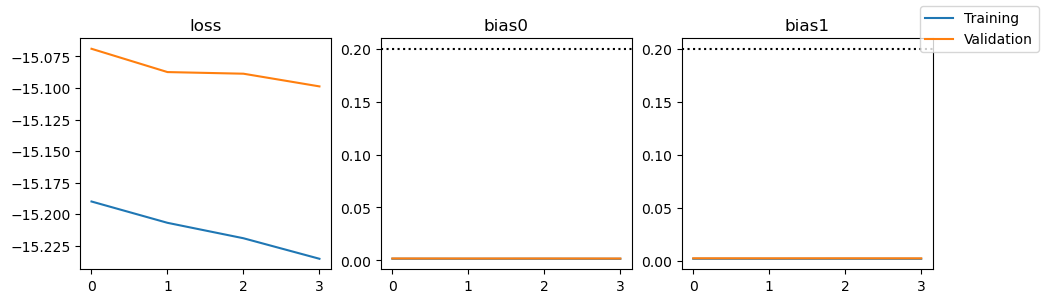

In [95]:
plotLearningGraphs(model.history.history, metric_list = ['loss', 'bias0', 'bias1'])

#### From PI0

In [99]:
pi0 = [item[:, :, :, 0:1] for item in circle_pipeline_pi.all_vecs]

model = tf.keras.Sequential(
    [
        ExtraDimLayer(tf.keras.layers.Conv2D(8, (3,3), padding='same', activation = "relu", input_shape=(res, res, 1))),
        ExtraDimLayer(tf.keras.layers.MaxPooling2D((2, 2), strides=2)),
        ExtraDimLayer(tf.keras.layers.Flatten()),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(2)
    ]
)
pi_imnn_layer = IMNNLayer(model, verbose = 0, epochs = 30, data_splits = [0.4, 0.2, 0.4], \
                            callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)], \
                          reg = tf.constant(0.), show_bias = True, show_fi = True)

fisher = pi_imnn_layer.computeFisher(pi0, circle_pipeline_pi.delta_theta)

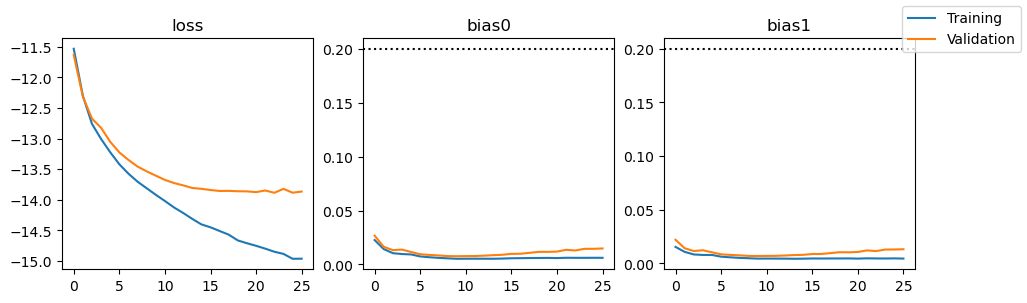

In [101]:
plotLearningGraphs(model.history.history, metric_list = ['loss', 'bias0', 'bias1'])

In [102]:
show_fm_and_bias(fisher)

log FI =  13.91
FM =  [ 732.71 1271.53 1271.53 3707.06]
Fractional bias =  [0. 0.]
Constraints =  [0.05806728 0.02581568]


In [118]:
vectorizations = [TOPK(bdp_type = "bd", is_binned = True, topk = 219, num_bins = 24), \
                  #TOPK(bdp_type = "bd", is_binned = True, topk = 25, num_bins = 5)
                 ]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [0])
show_fm_and_bias(circle_pipeline.vectorize_and_fisher(vecLayer, MopedLayer()))

log FI =  13.21
FM =  [ 629.5  1477.99 1477.99 4340.92]
Fractional bias =  [0. 0.]
Constraints =  [0.08898897 0.0338879 ]


#### From PI1

In [113]:
pi1[0].shape

(10000, 24, 24, 1)

In [114]:
pi1 = [item[:, :, :, 1:2] for item in circle_pipeline_pi.all_vecs]
model = tf.keras.Sequential(
    [
        ExtraDimLayer(tf.keras.layers.Conv2D(8, (3,3), padding='same', activation = "relu", input_shape=(res, res, 1))),
        ExtraDimLayer(tf.keras.layers.MaxPooling2D((2, 2), strides=2)),
        ExtraDimLayer(tf.keras.layers.Flatten()),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(2)
    ]
)
pi_imnn_layer = IMNNLayer(model, verbose = 1, epochs = 100, data_splits = [0.4, 0.2, 0.4], \
                            callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)], \
                          reg = tf.constant(0.), show_bias = True, show_fi = True)

fisher = pi_imnn_layer.computeFisher(pi1, circle_pipeline_pi.delta_theta)

Epoch 1/100
8/8 [==============================] - 8s 512ms/step - loss: -11.3345 - lnfi: 11.3440 - bias0: 0.0188 - bias1: 0.0267 - val_loss: -11.8934 - val_lnfi: 11.8903 - val_bias0: 0.0081 - val_bias1: 0.0154
Epoch 2/100
8/8 [==============================] - 2s 307ms/step - loss: -12.2244 - lnfi: 12.2256 - bias0: 0.0041 - bias1: 0.0091 - val_loss: -12.4055 - val_lnfi: 12.4016 - val_bias0: 0.0048 - val_bias1: 0.0110
Epoch 3/100
8/8 [==============================] - 2s 307ms/step - loss: -12.7533 - lnfi: 12.7617 - bias0: 0.0029 - bias1: 0.0086 - val_loss: -12.8369 - val_lnfi: 12.8331 - val_bias0: 0.0050 - val_bias1: 0.0132
Epoch 4/100
8/8 [==============================] - 2s 310ms/step - loss: -13.2479 - lnfi: 13.2481 - bias0: 0.0043 - bias1: 0.0107 - val_loss: -13.1065 - val_lnfi: 13.0985 - val_bias0: 0.0048 - val_bias1: 0.0127
Epoch 5/100
8/8 [==============================] - 2s 304ms/step - loss: -13.5573 - lnfi: 13.5619 - bias0: 0.0040 - bias1: 0.0100 - val_loss: -13.2937 - val

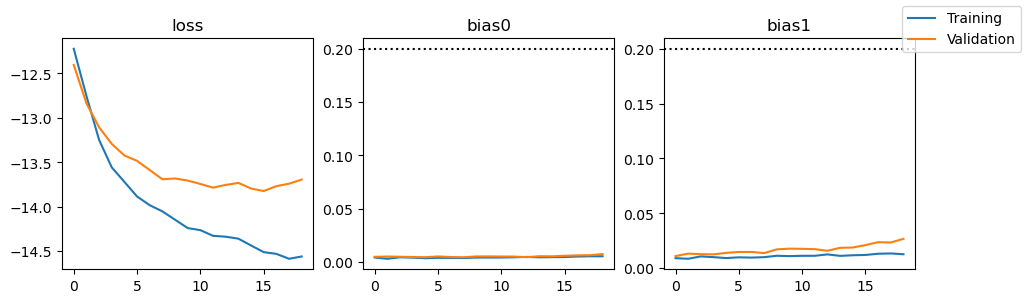

In [115]:
plotLearningGraphs(model.history.history, metric_list = ['loss', 'bias0', 'bias1'])


In [116]:
show_fm_and_bias(fisher)

log FI =  13.65
FM =  [ 549.28 -183.6  -183.6  1597.31]
Fractional bias =  [0. 0.]
Constraints =  [0.04351194 0.02551595]


In [110]:
vectorizations = [#TOPK(bdp_type = "bd", is_binned = True, topk = 219, num_bins = 24), \
                  TOPK(bdp_type = "bd", is_binned = True, topk = 25, num_bins = 5)]

vecLayer = VectorizationLayers(vectorizations = vectorizations, pds_idx_list = [1])
show_fm_and_bias(circle_pipeline.vectorize_and_fisher(vecLayer, MopedLayer()))

log FI =  13.51
FM =  [ 379.46  137.04  137.04 1996.11]
Fractional bias =  [0. 0.]
Constraints =  [0.05198373 0.02266519]


In [110]:
a = 1000; b = 100;
for idx in range(8) :
    print(a//2, b//2)
    a = a//2
    b = b//2

500 50
250 25
125 12
62 6
31 3
15 1
7 0
3 0


In [122]:
N = 1005;
M = 105
f = np.zeros([N, M]) + 10000000
for i in tqdm(range(N)):
    for j in range(M):
        mat = np.concatenate([f[i, :j], f[:i, j]]) 

        for k in range(2*N + M) :
            if k not in mat : 
                f[i,j] = k
                break
        

100%|██████████| 1005/1005 [03:32<00:00,  4.73it/s]


In [123]:
f[1000, 100]

908.0

In [ ]:
mat = np.concatenate([f[1000, :100], f[:i, j]]) 
# mat = np.sort(mat)
for k in range(N + M) :
    if k not in mat : 
        print (k)
        break